In [48]:
import seaborn as sns
# set font-scale
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [49]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            dfs.append(results_df)
    df = pd.concat(dfs)
    return df

In [50]:
df = load_csvs_into_df('./')

In [51]:
df['weight'] = df['weigh_loss'].str.extract(r'.*_([0-9]+.[0-9]+)').astype(float)
# only keep relevant columns
df = df[['seed','weight','test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC','protected_attr_percent']]

In [52]:
df = pd.melt(df, id_vars=['seed','protected_attr_percent','weight'], value_vars=['test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC'])
df.head()

,seed,protected_attr_percent,weight,variable,value
0,2,0.5,0.01,test/lungOpacity_young_subgroupAUROC,0.8014
1,1,0.5,0.01,test/lungOpacity_young_subgroupAUROC,0.7816
2,8,0.5,0.01,test/lungOpacity_young_subgroupAUROC,0.8192
3,5,0.5,0.01,test/lungOpacity_young_subgroupAUROC,0.8200
4,6,0.5,0.01,test/lungOpacity_young_subgroupAUROC,0.8428


In [53]:
# load weight 1 data-sets
df_1 = load_csvs_into_df('../2023.07.11-20:38:32-FAE-rsna-age-bs32-noDP')
df_1 = df_1[['seed','test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC','protected_attr_percent']]
df_1['weight'] = 1
df_1 = pd.melt(df_1, id_vars=['seed','protected_attr_percent','weight'], value_vars=['test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC'])
# only select rows where protected_attr_percent is 0.25, 0.5, 0.75
df_1 = df_1[df_1.protected_attr_percent.isin([0.25,0.5,0.75])]
df_1.head()

,seed,protected_attr_percent,weight,variable,value
0,10,0.25,1,test/lungOpacity_young_subgroupAUROC,0.7728
1,9,0.25,1,test/lungOpacity_young_subgroupAUROC,0.7686
2,2,0.25,1,test/lungOpacity_young_subgroupAUROC,0.7596
3,1,0.25,1,test/lungOpacity_young_subgroupAUROC,0.7708
4,8,0.25,1,test/lungOpacity_young_subgroupAUROC,0.7726


In [54]:
# concat df and df_1
df = pd.concat([df,df_1])

In [55]:
# sort list ascending
fractions = df.protected_attr_percent.unique()
fractions.sort()

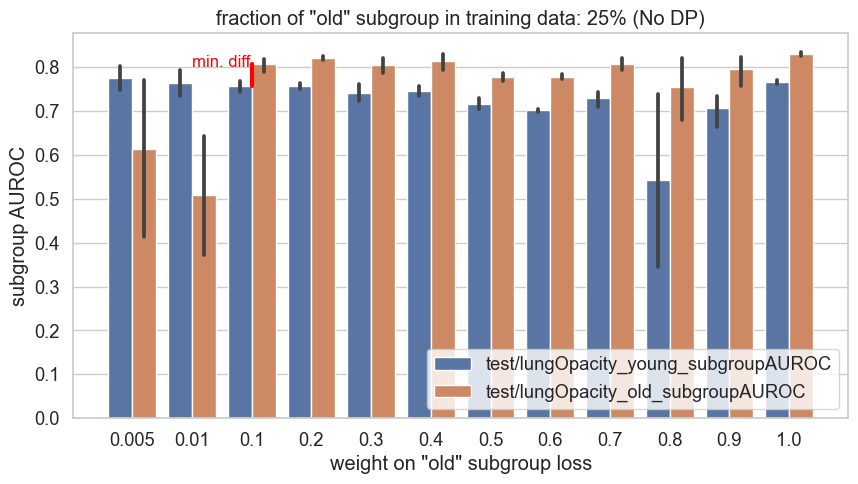

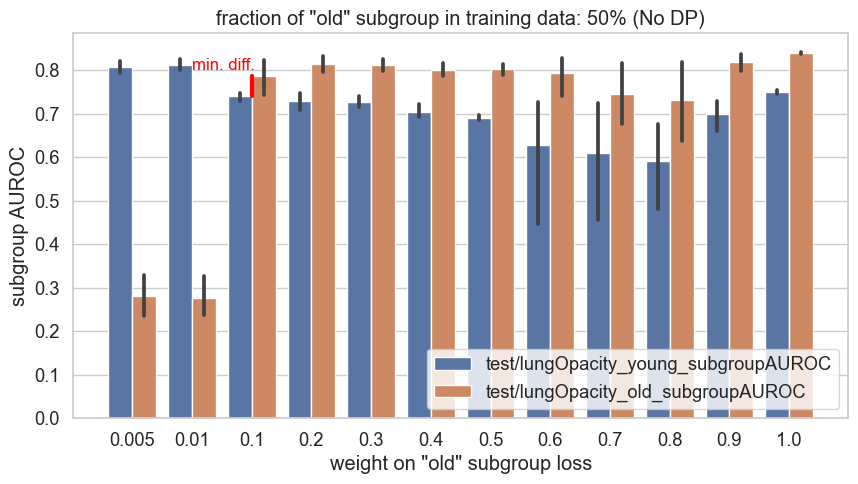

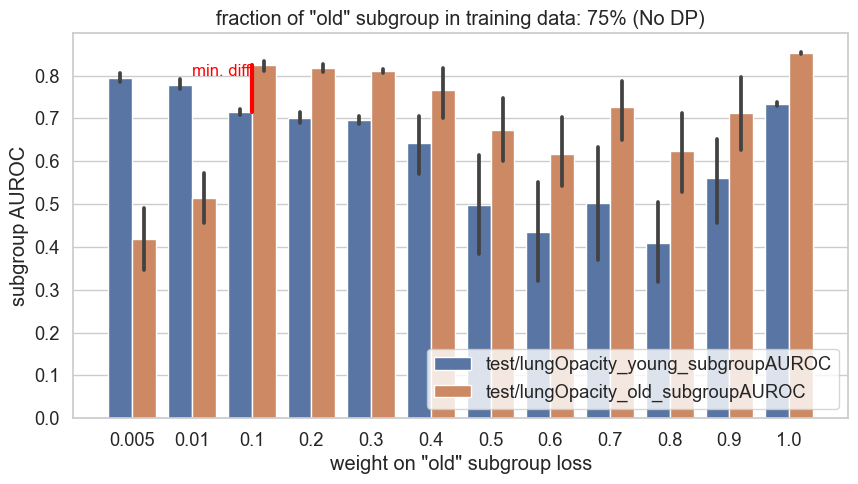

In [56]:
for f in fractions:
    plt.figure(figsize=(10,5))
    sub = df[df.protected_attr_percent==f]
    # group by weight
    sub_grouped = sub.groupby(['weight','variable']).mean().reset_index()
    # over all weights get weight with minimum dist between young and old subgroup AUROC
    min_dist = np.inf
    best_weight = None
    best_weight_max = None
    best_weight_min = None
    for w in sub_grouped.weight.unique():
        sub_grouped_w = sub_grouped[sub_grouped.weight==w]
        # compute dist between max and min of value column
        dist = sub_grouped_w.value.max() - sub_grouped_w.value.min()
        if dist < min_dist:
            min_dist = dist
            best_weight = w
            best_weight_max = sub_grouped_w.value.max()
            best_weight_min = sub_grouped_w.value.min()
    sns.barplot(data=sub, x="weight", y="value", hue="variable")
    # create vertical line at best weight
    plt.plot([best_weight*20, best_weight*20], [best_weight_min, best_weight_max], color='red', linestyle='-', linewidth=3)
    # add text at same location
    plt.text(best_weight*10, 0.8, f'min. diff.', fontsize=12, color="red")
    plt.title(f'fraction of "old" subgroup in training data: {f*100:.0f}% (No DP)')
    # set axis labels
    plt.xlabel('weight on "old" subgroup loss')
    plt.ylabel('subgroup AUROC')
    plt.legend(loc="lower right")
    plt.show()